In [1]:
import torch
import pickle
from matplotlib import pyplot as plt
import numpy as np
from itertools import chain
from helper.model import *
from helper.utils import *
from helper.distance_map import *
from helper.evaluate import *
from scipy import stats
from tqdm import tqdm
import pandas as pd
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

args_train_data = "uniref100_full"
args_test_data = "price_149"
#args_test_data = "new"
args_model_name = "split100_ensemble/split100_"  
args_weight_path = "uncertainty_ensemble/" 
args_N_models = 8

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32
#
id_ec_train, ec_id_dict_train = get_ec_id_dict('./data/'+args_train_data+'.csv')
id_ec_test, _ = get_ec_id_dict('./data/'+args_test_data+'.csv')

In [ ]:
# keep models output embeddings
esm_embedding_train = esm_embedding(ec_id_dict_train, device, dtype)

for i in (range(args_N_models)):
    model_i = LayerNormNet(512, 128, device, dtype)
    model_name_i = args_model_name + str(i)
    print("loading model:", model_name_i)
    checkpoint = torch.load('./model/' + model_name_i + '.pth')
    model_i.load_state_dict(checkpoint)
    model_i.eval()
    emb_train_i = model_i(esm_embedding_train) 
    emb_test_i = model_embedding_test(id_ec_test, model_i, device, dtype) 
    emb_train_i_path = args_weight_path+args_test_data+"_emb_train_"+str(i)+'.pt'
    emb_test_i_path = args_weight_path+args_test_data+"_emb_test_"+str(i)+'.pt'
    torch.save(emb_train_i, emb_train_i_path)
    torch.save(emb_test_i, emb_test_i_path)

In [2]:
# get distance map for all models
eval_dist_lst_all = []
for i in (range(args_N_models)):
    emb_train_i_path = args_weight_path+args_test_data+"_emb_train_"+str(i)+'.pt'
    emb_test_i_path = args_weight_path+args_test_data+"_emb_test_"+str(i)+'.pt'
    emb_train = torch.load(emb_train_i_path)
    emb_test = torch.load(emb_test_i_path)
    eval_dist = get_dist_map_test(
            emb_train, emb_test, ec_id_dict_train, id_ec_test, 
            device, dtype, dot=False)
    eval_dist_lst_all.append(eval_dist)

The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([149, 128])


100%|██████████| 5242/5242 [00:01<00:00, 3772.58it/s]


Calculating eval distance map, between 149 test ids and 5242 train EC cluster centers


149it [00:00, 834.74it/s]


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([149, 128])


100%|██████████| 5242/5242 [00:00<00:00, 9253.31it/s] 


Calculating eval distance map, between 149 test ids and 5242 train EC cluster centers


149it [00:00, 748.74it/s]


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([149, 128])


100%|██████████| 5242/5242 [00:00<00:00, 12723.27it/s]


Calculating eval distance map, between 149 test ids and 5242 train EC cluster centers


149it [00:00, 668.16it/s]


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([149, 128])


100%|██████████| 5242/5242 [00:00<00:00, 11687.88it/s]


Calculating eval distance map, between 149 test ids and 5242 train EC cluster centers


149it [00:00, 790.45it/s]


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([149, 128])


100%|██████████| 5242/5242 [00:00<00:00, 13204.11it/s]


Calculating eval distance map, between 149 test ids and 5242 train EC cluster centers


149it [00:00, 925.47it/s]


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([149, 128])


100%|██████████| 5242/5242 [00:00<00:00, 13287.91it/s]


Calculating eval distance map, between 149 test ids and 5242 train EC cluster centers


149it [00:00, 908.55it/s]


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([149, 128])


100%|██████████| 5242/5242 [00:00<00:00, 13187.37it/s]


Calculating eval distance map, between 149 test ids and 5242 train EC cluster centers


149it [00:00, 856.32it/s]


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([149, 128])


100%|██████████| 5242/5242 [00:00<00:00, 11024.13it/s]


Calculating eval distance map, between 149 test ids and 5242 train EC cluster centers


149it [00:00, 707.85it/s]


In [3]:
def get_precision_bins(eval_dist_lst, N_bins=6, N_random_models=5,
                       use_std_pred=True):
    # use_std_pred: whether use percentile 
    # calculated from maxsep predictions only
    ############################################################
    eval_dist_w_std = dict()
    eval_dist_mean = dict()
    # keep track of all query/ec dist std for future ranking
    all_dist_std = []
    # calculate distance map with standard deviation
    print("calculating mean distance and std")
    for query in  tqdm(eval_dist_lst[0].keys()):
        dist_mean_std = dict()
        dist_mean_dict = dict()
        # get the ec/distance dictionary
        for ec in eval_dist_lst[0][query]:
            # find distances for this query/ec pair for these models
            all_dist_per_ec = []
            for i in range(N_random_models):
                all_ec_dist_per_query = eval_dist_lst[i][query] 
                dist_i = all_ec_dist_per_query[ec]
                all_dist_per_ec.append(dist_i)
            dist_mean = np.mean(all_dist_per_ec)
            dist_std = np.std(all_dist_per_ec)
            all_dist_std.append(dist_std)
            dist_mean_std[ec] = (dist_mean, dist_std)
            dist_mean_dict[ec] = dist_mean
        eval_dist_w_std[query] = dist_mean_std
        eval_dist_mean[query] = dist_mean_dict
    ############################################################
    # get max sep prediction results for all models
    certainty_from_all_dist_lst = []
    certainty_from_dist_in_pred_lst = []
    all_std_in_pred_lst = []
    dist_map_df = pd.DataFrame.from_dict(eval_dist_mean); 
    first_grad=True; use_max_grad=False
    # get predictions
    query_prediction_lst = []
    for query in tqdm(dist_map_df.columns):
        smallest_10_dist_df = dist_map_df[query].nsmallest(10)
        dist_lst = list(smallest_10_dist_df)
        max_sep_i = maximum_separation(dist_lst, first_grad, use_max_grad)
        predictions = []
        for i in range(max_sep_i+1):
            EC_i = smallest_10_dist_df.index[i]
            dist_i = smallest_10_dist_df[i]
            predictions.append((EC_i, dist_i))
            _, dist_std = eval_dist_w_std[query][EC_i]
            # keep track of all dist std appeared in prediction
            all_std_in_pred_lst.append(dist_std)
            #print(query, EC_i, dist_std, perc_certainty)
        query_prediction_lst.append((query, predictions))
    ############################################################
    bins_query_by_certainty = [[] for i in range(N_bins)]
    query_count = 0
    for query in tqdm(dist_map_df.columns):
        smallest_10_dist_df = dist_map_df[query].nsmallest(10)
        dist_lst = list(smallest_10_dist_df)
        max_sep_i = maximum_separation(dist_lst, first_grad, use_max_grad)
        # bin by minimum certainty
        certainty_per_query = []
        for i in range(max_sep_i+1):
            EC_i = smallest_10_dist_df.index[i]
            dist_i = smallest_10_dist_df[i]
            predictions.append((EC_i, dist_i))
            _, dist_std = eval_dist_w_std[query][EC_i]
            # certainty by all distance std in distance map
            perc_certainty = 1 - stats.percentileofscore(
                all_dist_std, dist_std, 'rank')/100
            certainty_from_all_dist_lst.append(perc_certainty)
            # certainty by all distance std in prediction
            perc_certainty_in_pred = 1 - stats.percentileofscore(
                all_std_in_pred_lst, dist_std, 'rank')/100
            certainty_from_dist_in_pred_lst.append(perc_certainty_in_pred)
            ###################################
            if use_std_pred:
                certainty_per_query.append(perc_certainty_in_pred) # perc method 2)
            else:
                certainty_per_query.append(perc_certainty) # perc method 1)
                
        for bin_i in range(N_bins):
            lower, upper = bin_i/N_bins, (bin_i+1)/N_bins
            for certainty in certainty_per_query:
                if certainty >= lower and certainty < upper:
                    bins_query_by_certainty[bin_i].append(query_count)
        query_count += 1
    
    ############################################################
    # write the top 10 closest EC to _top10.csv
    out_filename = './eval/' + args_test_data
    # _ = write_top10_choices(eval_df, out_filename)
    # maximum separation results
    write_max_sep_choices(dist_map_df, out_filename, first_grad=True, use_max_grad=False)
    # get preds and true labels
    pred_label = get_pred_labels(out_filename, pred_type='_maxsep')
    pred_probs = get_pred_probs(out_filename, pred_type='_maxsep')
    true_label, all_label = get_true_labels('./data/'+args_test_data)
    pre, rec, f1, roc, acc = get_eval_metrics_new(
        pred_label, pred_probs, true_label, all_label)
    results_all = (pre, rec, f1, roc, acc)
    
    print("Overall size:", len(pred_label))
    print("overall:", pre, rec, f1, roc, acc)
    # collect results by bin
    results_per_bin = [] 
    for bin_i in range(N_bins):
        query_bin = bins_query_by_certainty[bin_i]
        pred_label_i = [pred_label[i] for i in query_bin]
        pred_probs_i = [pred_probs[i] for i in query_bin]
        true_label_i = [true_label[i] for i in query_bin]
        all_label_i = set(list(chain.from_iterable(true_label_i)))
        #print(pred_label_i, pred_probs_i, true_label_i, all_label_i)
        # print(pred_label_i, pred_probs_i, true_label_i)
        # raise
        # print("bin:", bin_i, len(pred_label_i))
        # print("bin:", bin_i, pre, rec, f1, roc, acc)
        pre, rec, f1, roc, acc = get_eval_metrics_new(
            pred_label_i, pred_probs_i, true_label_i, all_label_i)
        results_per_bin.append((pre, rec, f1, roc, acc))

    return results_per_bin, results_all

In [4]:
args_N_experiment = 15
args_N_random_models = 5
args_N_bins = 10
# randomly choose models to do ensemble
np.random.seed(1)
models_experiments = [np.random.choice(8, 5, replace=False) 
                      for i in range(args_N_experiment)]

In [ ]:
result_bin_per_experiment = []
result_all_per_experiment = []
for experiment in models_experiments:
    eval_dist_lst = [eval_dist_lst_all[model] for model in experiment] 
    results_per_bin, results_all = get_precision_bins(
        eval_dist_lst, N_random_models=args_N_random_models,
        N_bins=args_N_bins, use_std_pred=True)
    result_bin_per_experiment.append(results_per_bin)
    result_all_per_experiment.append(results_all)

In [13]:
with open('uncertainty_ensemble/price_non_cumulative.pkl', 'wb') as f:
    pickle.dump((result_bin_per_experiment, result_all_per_experiment), f)
with open('uncertainty_ensemble/price_non_cumulative.pkl', 'rb') as f:
    result_bin_per_experiment, result_all_per_experiment = pickle.load(f)

In [6]:
# clean over all metrics for experiments 
pre_all, rec_all, f1_all, roc_all, acc_all = [], [], [], [], []
for i in range(args_N_experiment):
    result_all_i = result_all_per_experiment[i]
    pre, rec, f1, roc, acc = result_all_i
    pre_all.append(pre); rec_all.append(rec); f1_all.append(f1);
    roc_all.append(roc); acc_all.append(acc)
pre_all_avg = np.mean(pre_all)
rec_all_avg = np.mean(rec_all)
f1_all_avg = np.mean(f1_all)
roc_all_avg = np.mean(roc_all)
acc_all_avg = np.mean(acc_all)

In [7]:
pre_rec_f1_roc_acc_mean = [[] for i in range(5)]
pre_rec_f1_roc_acc_std = [[] for i in range(5)]

for bin_i in range(args_N_bins):
    result_bin_i = [result_bin_per_experiment[i][bin_i]
                    for i in range(args_N_experiment)]
    metrics_mean = np.mean(result_bin_i, axis=0)
    metrics_std = np.std(result_bin_i, axis=0)
    for i in range(5):
        # add each metrics for bin_i
        pre_rec_f1_roc_acc_mean[i].append(metrics_mean[i])
        pre_rec_f1_roc_acc_std[i].append(metrics_std[i])


## Precision

Average precision across all experiments: 0.5896929824561403


Text(0.5, 1.0, 'Uncertainty quantification for price_149')

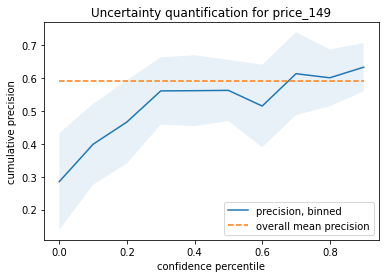

In [14]:
print("Average precision across all experiments:", pre_all_avg)
pre_bin_mean = pre_rec_f1_roc_acc_mean[0]
pre_bin_std = pre_rec_f1_roc_acc_std[0]
 
confidence_range = [i/args_N_bins for i in range(args_N_bins)]
# precision average over experiment, binned
plt.plot(confidence_range, pre_bin_mean,
         label='precision, binned')
# average overall precision
plt.plot(confidence_range, [pre_all_avg for i in range(args_N_bins)], 
         '--', label='overall mean precision')
lower = np.array(pre_bin_mean) - np.array(pre_bin_std)
upper = np.array(pre_bin_mean) + np.array(pre_bin_std)
plt.fill_between(confidence_range, lower, upper, alpha=.1)
plt.xlabel("confidence percentile")
plt.ylabel("cumulative precision")
plt.legend(loc='lower right')
plt.title("Uncertainty quantification for " + args_test_data)

## Recall

Average recall across all experiments: 0.44649122807017533


Text(0.5, 1.0, 'Uncertainty quantification for price_149')

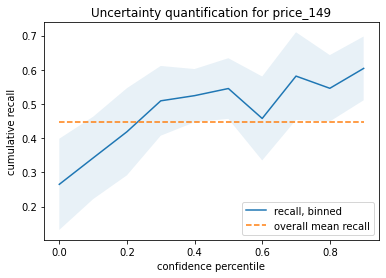

In [9]:
print("Average recall across all experiments:", rec_all_avg)
rec_bin_mean = pre_rec_f1_roc_acc_mean[1]
rec_bin_std = pre_rec_f1_roc_acc_std[1]

confidence_range = [i/args_N_bins for i in range(args_N_bins)]
# recall average over experiment, binned
plt.plot(confidence_range, rec_bin_mean,
         label='recall, binned')
# average overall recall
plt.plot(confidence_range, [rec_all_avg for i in range(args_N_bins)], 
         '--', label='overall mean recall')

lower = np.array(rec_bin_mean) - np.array(rec_bin_std)
upper = np.array(rec_bin_mean) + np.array(rec_bin_std)
plt.fill_between(confidence_range, lower, upper, alpha=.1)
plt.xlabel("confidence percentile")
plt.ylabel("cumulative recall")
plt.legend(loc='lower right')
plt.title("Uncertainty quantification for " + args_test_data)

## F1

Average F1 across all experiments: 0.4788337146599531


Text(0.5, 1.0, 'Uncertainty quantification for price_149')

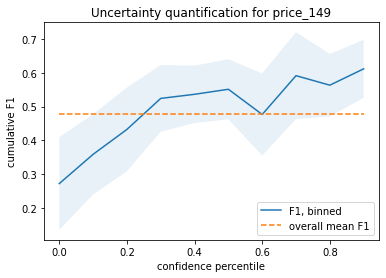

In [10]:
print("Average F1 across all experiments:", f1_all_avg)
f1_bin_mean = pre_rec_f1_roc_acc_mean[2]
f1_bin_std = pre_rec_f1_roc_acc_std[2]
confidence_range = [i/args_N_bins for i in range(args_N_bins)]
# f1 average over experiment, binned
plt.plot(confidence_range, f1_bin_mean,
         label='F1, binned')
# average overall F1
plt.plot(confidence_range, [f1_all_avg for i in range(args_N_bins)], 
         '--', label='overall mean F1')

lower = np.array(f1_bin_mean) - np.array(f1_bin_std)
upper = np.array(f1_bin_mean) + np.array(f1_bin_std)
plt.fill_between(confidence_range, lower, upper, alpha=.1)
plt.xlabel("confidence percentile")
plt.ylabel("cumulative F1")
plt.legend(loc='lower right')
plt.title("Uncertainty quantification for " + args_test_data)

### AUC

Average AUC across all experiments: 0.7230925242203436


Text(0.5, 1.0, 'Uncertainty quantification for price_149')

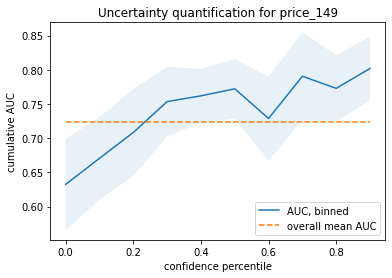

In [11]:
print("Average AUC across all experiments:", roc_all_avg)
roc_bin_mean = pre_rec_f1_roc_acc_mean[3]
roc_bin_std = pre_rec_f1_roc_acc_std[3]
confidence_range = [i/args_N_bins for i in range(args_N_bins)]
# AUC average over experiment, binned
plt.plot(confidence_range, roc_bin_mean,
         label='AUC, binned')
# average overall F1
plt.plot(confidence_range, [roc_all_avg for i in range(args_N_bins)], 
         '--', label='overall mean AUC')

lower = np.array(roc_bin_mean) - np.array(roc_bin_std)
upper = np.array(roc_bin_mean) + np.array(roc_bin_std)
plt.fill_between(confidence_range, lower, upper, alpha=.1)
plt.xlabel("confidence percentile")
plt.ylabel("cumulative AUC")
plt.legend(loc='lower right')
plt.title("Uncertainty quantification for " + args_test_data)

## Accuracy

Average accuracy across all experiments: 0.4519015659955257


Text(0.5, 1.0, 'Uncertainty quantification for price_149')

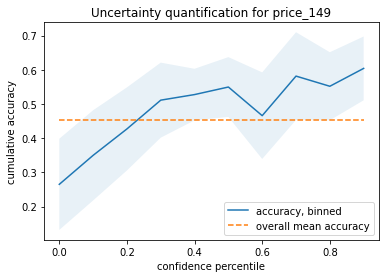

In [12]:
print("Average accuracy across all experiments:", acc_all_avg)
acc_bin_mean = pre_rec_f1_roc_acc_mean[4]
acc_bin_std = pre_rec_f1_roc_acc_std[4]
confidence_range = [i/args_N_bins for i in range(args_N_bins)]
# AUC average over experiment, binned
plt.plot(confidence_range, acc_bin_mean,
         label='accuracy, binned')
# average overall F1
plt.plot(confidence_range, [acc_all_avg for i in range(args_N_bins)], 
         '--', label='overall mean accuracy')

lower = np.array(acc_bin_mean) - np.array(acc_bin_std)
upper = np.array(acc_bin_mean) + np.array(acc_bin_std)
plt.fill_between(confidence_range, lower, upper, alpha=.1)
plt.xlabel("confidence percentile")
plt.ylabel("cumulative accuracy")
plt.legend(loc='lower right')
plt.title("Uncertainty quantification for " + args_test_data)